In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.layers import Conv1D, Flatten, Dropout, Dense, LSTM
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import np_utils

from tqdm import tqdm
import gensim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#from lime import lime_text
#from lime.lime_text import LimeTextExplainer

Using TensorFlow backend.


In [2]:
def init(embeddings_type = 'w2v'):
    if embeddings_type == 'w2v':    
        global w2vModel
        w2vModel = load_w2v_embeddings(w2v_path)
    else:
        raise NameError('Invalid embedding type {}'.format(embeddings_type))
        
def get_embeddings(embeddings_type = 'w2v'):
    if embeddings_type == 'w2v':
        global w2vModel
        try:
            return w2vModel
        except NameError:
            init(embeddings_type)
            return w2vModel
    else:
        raise NameError('Invalid embedding type %s' % embeddings_type)

def load_w2v_embeddings(path):
    w2vModel = gensim.models.KeyedVectors.load_word2vec_format(path, 
                                                               binary=False)
    return w2vModel 

class FixedSizeArray():
    def __init__(self, dimensions, timesteps, word2vec_mod=None):
        self.dim = dimensions
        self.steps = timesteps
        self.w2v = word2vec_mod
        
    def fit_transform(self, texts, y=None):
        return self.transform(texts, y)
    
    def fit(self, texts):
        return None
    
    def _transform(self, article):
        tokens = CountVectorizer().build_tokenizer()(article) 
        doc_vectors_gen = (self.w2v[a].tolist() for a in tokens if a in self.w2v.vocab)
        doc_vectors = [a for (i, a) in enumerate(doc_vectors_gen) if i <self.steps]
        
        while len(doc_vectors) < self.steps:
            doc_vectors.append([0])
    
        pad_vectors = pad_sequences(doc_vectors,padding='post',dtype='float32', maxlen=self.dim, value=0.)
        return pad_vectors
    
    def transform(self, sentences, y=None):
        
        if self.w2v == None:
            print("Lazy loading embeddings...")
            self.w2v = get_embeddings('w2v')
        
        sentences = [eval(i) for i in sentences]
        return np.array([self._transform(' '.join(i)) for i in sentences])
    
def plot_training(history):
    plt.figure(figsize=(12, 12))
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    plt.figure(figsize=(12, 12))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    
def create_conv_model(dropout, kernel_size=3):
    model = Sequential()
    model.add(Conv1D(64, kernel_size, input_shape=(10, 100), padding='same'))
    model.add(Conv1D(32, kernel_size, padding='same'))
    model.add(Conv1D(16, kernel_size, padding='same'))
    model.add(Flatten())
    model.add(Dropout(dropout))
    model.add(Dense(180, activation='sigmoid'))
    model.add(Dropout(dropout))
    model.add(Dense(3, activation='softmax'))
    return model

def create_simple_LSTM_model():
    model = Sequential()
    model.add(LSTM(128, input_shape = (10, 100), return_sequences=True))
    model.add(SpatialDropout1D(0.4))
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(3,activation='softmax'))
    return model

def create_LSTM_model():
    model = Sequential()
    model.add(LSTM(256, input_shape = (10, 100), return_sequences=True, recurrent_dropout=0.2))
    model.add(SpatialDropout1D(0.4))
    model.add(LSTM(128, return_sequences=True, recurrent_dropout=0.2))
    model.add(SpatialDropout1D(0.4))
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(3,activation='softmax'))
    return model

In [3]:
class NeuralNet(BaseEstimator, ClassifierMixin):
    
    def __init__(self, model, batchsize = 256, epochs = 10):
        self.model = model
        self.model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
        self.early_stopping = EarlyStopping(patience=2)
        self.checkpointer = ModelCheckpoint(filepath='weights.tmp.h5', verbose=1, save_best_only=True)
        self.batchsize = batchsize
        self.epochs = epochs
        
    def fit(self, X, y):
        history = self.model.fit(X, 
                                 y, 
                                 validation_split=0.1, 
                                 batch_size=self.batchsize, 
                                 epochs=self.epochs, 
                                 callbacks=[self.checkpointer, self.early_stopping])
        self.history = history
        
    def predict(self, X):
        return self.model.predict(X)

In [4]:
data_path = '/home/rafal/Documents/ey/my_solution/data/Data - sentiment classification.csv'
w2v_path = 'data/nkjp+wiki-forms-all-100-cbow-hs.txt'

In [ ]:
fsa = FixedSizeArray(100, 10)

In [ ]:
df = pd.read_csv(data_path, sep = '\t').drop('id', axis=1)
y = df.loc[:, 'sentiment'].values
x = df.loc[:, 'tokens'].values

encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
dummy_y = np_utils.to_categorical(encoded_y)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, dummy_y, test_size=0.33, random_state=42)

### Simple LSTM

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Lazy loading embeddings...
Instructions for updating:
Use tf.cast instead.
Train on 24963 samples, validate on 2774 samples
Epoch 1/10
24963/24963 [==============================] - 11s 434us/step - loss: 0.3289 - acc: 0.8494 - val_loss: 0.2616 - val_acc: 0.8794

Epoch 00001: val_loss improved from inf to 0.26164, saving model to weights.tmp.h5
Epoch 2/10
24963/24963 [==============================] - 9s 378us/step - loss: 0.2486 - acc: 0.8840 - val_loss: 0.2474 - val_acc: 0.8844

Epoch 00002: val_loss improved from 0.26164 to 0.24741, saving model to weights.tmp.h5
Epoch 3/10
24963/24963 [==============================] - 9s 377us/step - loss: 0.2269 - acc: 0.8979 - val_loss: 0.2289 - val_acc: 0.8983

Epoch 00003: val_loss improved from 0.24741 to 0.22891, saving model to weights.tmp.h5
Epoch 4/10
249

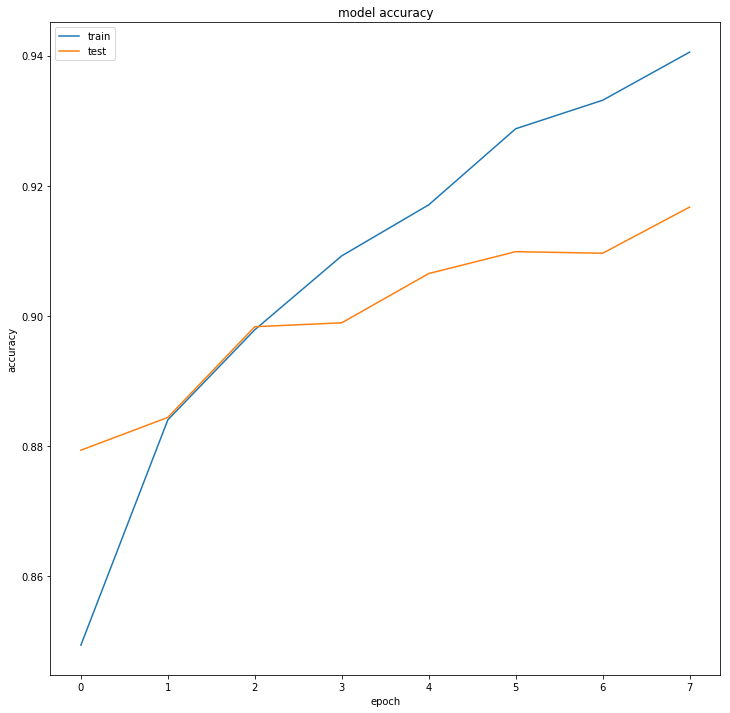

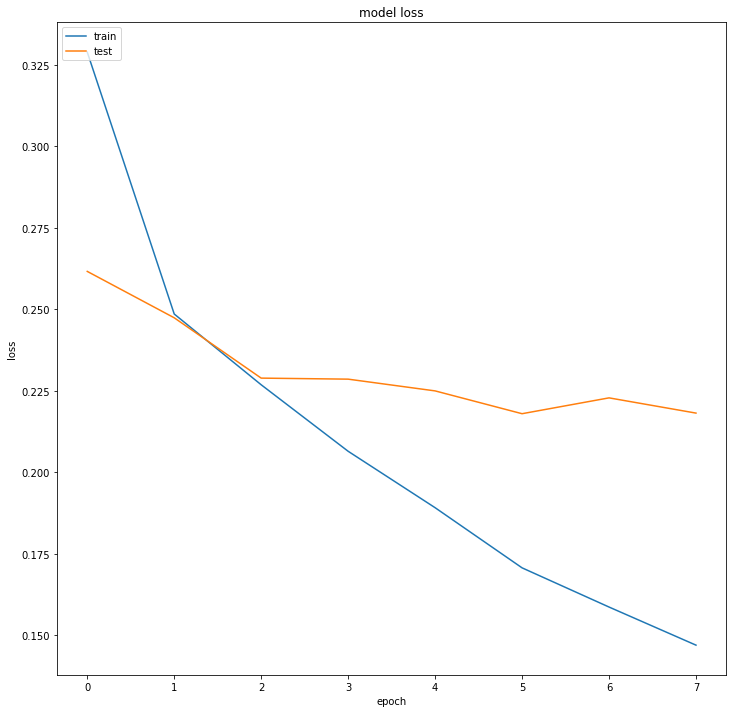

In [ ]:
model = Pipeline([
    ('fsa', FixedSizeArray(100, 10)),
    ('nn', NeuralNet(create_LSTM_model())),
])

model.fit(X_train, y_train)

plot_training(model.steps[1][1].history) 

In [ ]:
accuracy_score(model.predict(X_test).argmax(axis=1), y_test.astype(int).argmax(axis=1))

0.8640755379885815

### LSTM

Lazy loading embeddings...
Train on 24963 samples, validate on 2774 samples
Epoch 1/10
24963/24963 [==============================] - 11s 450us/step - loss: 0.3351 - acc: 0.8475 - val_loss: 0.2686 - val_acc: 0.8809

Epoch 00001: val_loss improved from inf to 0.26860, saving model to weights.tmp.h5
Epoch 2/10
24963/24963 [==============================] - 9s 380us/step - loss: 0.2530 - acc: 0.8813 - val_loss: 0.2449 - val_acc: 0.8872

Epoch 00002: val_loss improved from 0.26860 to 0.24489, saving model to weights.tmp.h5
Epoch 3/10
24963/24963 [==============================] - 10s 412us/step - loss: 0.2277 - acc: 0.8965 - val_loss: 0.2380 - val_acc: 0.8956

Epoch 00003: val_loss improved from 0.24489 to 0.23796, saving model to weights.tmp.h5
Epoch 4/10
24963/24963 [==============================] - 11s 437us/step - loss: 0.2079 - acc: 0.9075 - val_loss: 0.2210 - val_acc: 0.9034

Epoch 00004: val_loss improved from 0.23796 to 0.22102, saving model to weights.tmp.h5
Epoch 5/10
24963/2496

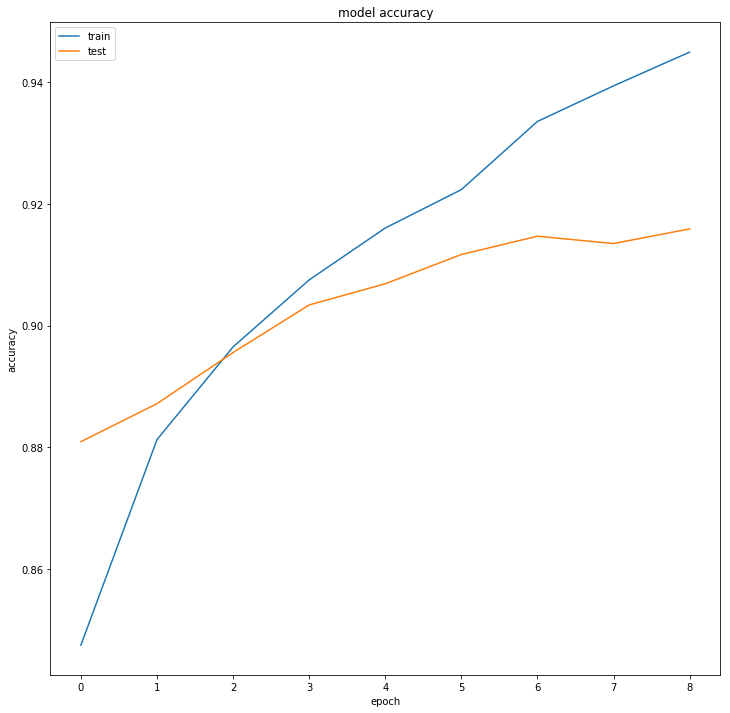

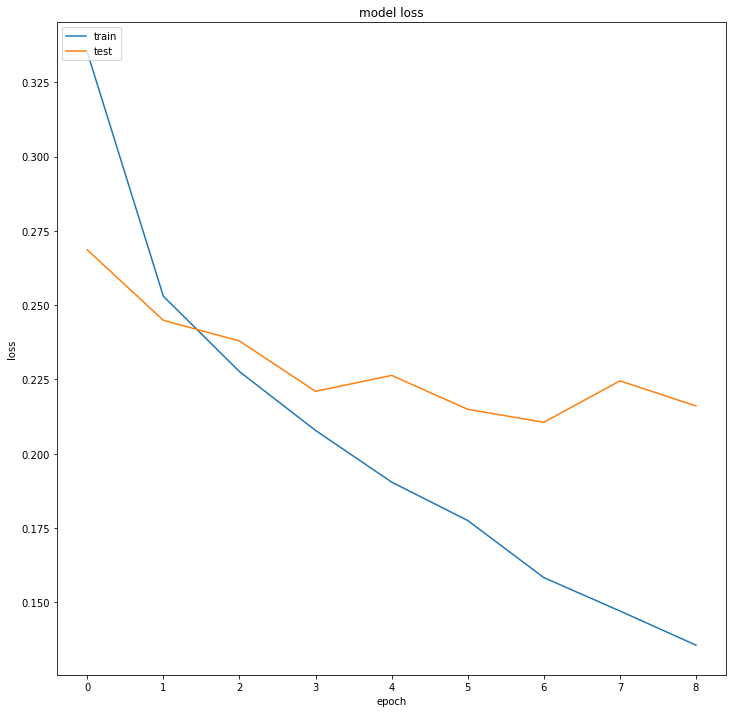

In [ ]:
model = Pipeline([
    ('fsa', FixedSizeArray(100, 10)),
    ('nn', NeuralNet(create_LSTM_model())),
])

model.fit(X_train, y_train)

plot_training(model.steps[1][1].history) 

In [ ]:
accuracy_score(model.predict(X_test).argmax(axis=1), y_test.astype(int).argmax(axis=1))

0.8665641926511491

### Conv1d

Lazy loading embeddings...
Train on 24963 samples, validate on 2774 samples
Epoch 1/10
24963/24963 [==============================] - 12s 493us/step - loss: 0.3285 - acc: 0.8475 - val_loss: 0.2609 - val_acc: 0.8798

Epoch 00001: val_loss improved from inf to 0.26088, saving model to weights.tmp.h5
Epoch 2/10
24963/24963 [==============================] - 14s 561us/step - loss: 0.2490 - acc: 0.8840 - val_loss: 0.2398 - val_acc: 0.8891

Epoch 00002: val_loss improved from 0.26088 to 0.23982, saving model to weights.tmp.h5
Epoch 3/10
24963/24963 [==============================] - 14s 553us/step - loss: 0.2280 - acc: 0.8955 - val_loss: 0.2354 - val_acc: 0.8943

Epoch 00003: val_loss improved from 0.23982 to 0.23537, saving model to weights.tmp.h5
Epoch 4/10
24963/24963 [==============================] - 14s 548us/step - loss: 0.2079 - acc: 0.9076 - val_loss: 0.2225 - val_acc: 0.9013

Epoch 00004: val_loss improved from 0.23537 to 0.22254, saving model to weights.tmp.h5
Epoch 5/10
24963/249

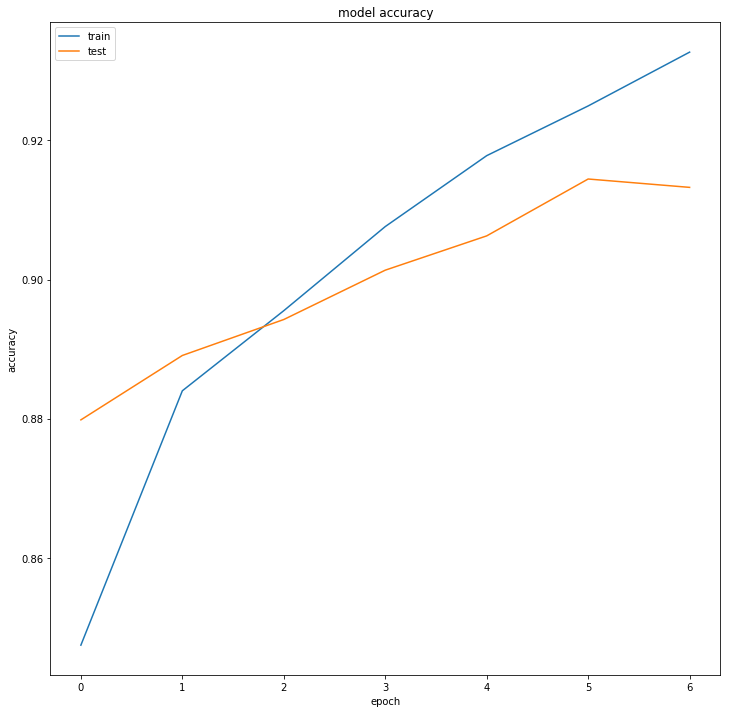

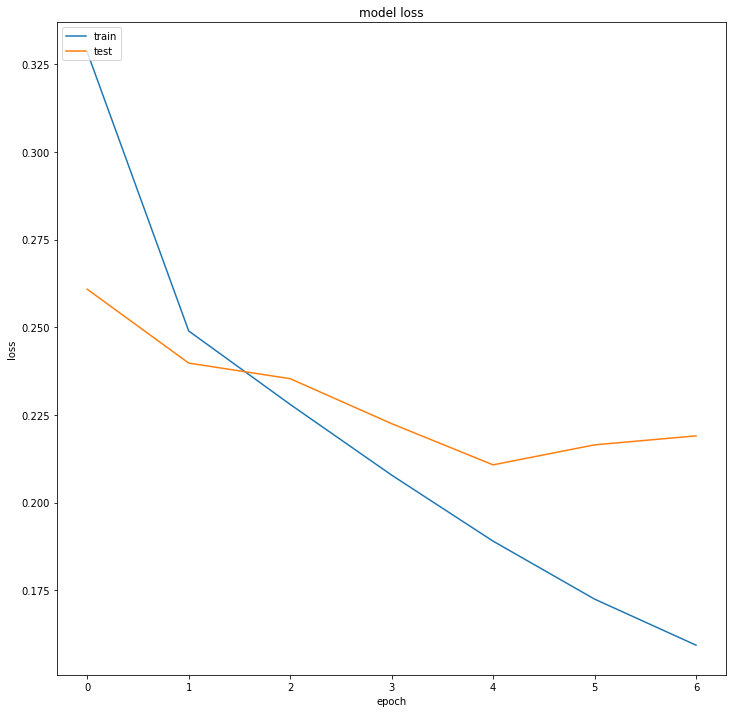

In [ ]:
model = Pipeline([
    ('fsa', FixedSizeArray(100, 10)),
    ('nn', NeuralNet(create_LSTM_model())),
])

model.fit(X_train, y_train)

plot_training(model.steps[1][1].history) 

In [ ]:
accuracy_score(model.predict(X_test).argmax(axis=1), y_test.astype(int).argmax(axis=1))